In [4]:
import math
import random
import time
from jupyterthemes import jtplot
jtplot.style()

import gym
gym.logger.set_level(40)
import numpy as np

import nnabla as nn
import nnabla.logger as logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solver as S
import nnabla.initializer as I
from nnabla.contrib.context import extension_context
from nnabla.monitor import Monitor, MonitorSeries, MonitorTimeElapsed

2018-08-17 16:26:13,670 [nnabla][INFO]: Initializing CPU extension...


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make("Hopper-v2")
state_num = env.observation_space.shape[0]
action_num = env.action_space.shape[0]
hidden_size = 128
max_frames = 200000
num_steps = 20000
batch_size = 32
gamma = 0.99
learning_rate = 1e-3
ppo_epochs = 10

plot_interval = 100
print(state_num,action_num)

Choosing the latest nvidia driver: /usr/lib/nvidia-396, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-396']
Choosing the latest nvidia driver: /usr/lib/nvidia-396, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-396']
11 3


In [52]:
#Actor:状態に対して行動の選択確率(方策)を返す
def Actor(state):
    with nn.parameter_scope("Actor"):
        with nn.parameter_scope("Actor-affine1"):
            h = F.relu(PF.affine(state, hidden_size))
        with nn.parameter_scope("Actor-affine2"):
            h = F.relu(PF.affine(h, hidden_size))
        with nn.parameter_scope("Actor-affine3"):
            A = PF.affine(h, action_num)
    return A

#Critic:状態に対して価値を返す
def Critic(state):
    with nn.parameter_scope("Critic"):
        with nn.parameter_scope("Critic-affine1"):
            h = F.relu(PF.affine(state, hidden_size))
        with nn.parameter_scope("Critic-affine2"):
            h = F.relu(PF.affine(h, hidden_size))
        with nn.parameter_scope("Critic-affine3"):
            C = PF.affine(h, 1)
    return C

def get_policy(state):
    State = nn.Variable([batch_size, state_num])
    State.d = state
    Policy = Actor(state)
    Policy.forward()
    return Policy #.d


def get_value(state):
    State = nn.Variable([batch_size, state_num])
    State.d = state
    Value = Critic(state)
    Value.forward()
    return Value.d #.d


array([[-9.026051e-06,  4.558704e-41, -9.026051e-06]], dtype=float32)

In [5]:
#変数定義
#State = nn.Variable([batch_size, state_num]) 
#Action = nn.Variable([batch_size, 1])
State = nn.Variable([100, state_num]) 
Action = nn.Variable([100, 1])

#TODO 損失関数に必要な関数を定義する
Policy = Actor(State)
Value = Critic(State)

tP_ = np.full((100, 3), 5.0)
tV_ = np.full((100, 1), -5.0)
tP = nn.Variable.from_numpy_array(tP_)
tV = nn.Variable.from_numpy_array(tV_)

loss_actor = F.squared_error(Policy,tP)
loss_critic = F.squared_error(Value,tV)
loss = loss_actor + loss_critic
               

#損失関数定義
#TODO Actor-Criticを解くための損失関数の定義を行う
#loss = 


#solver定義
solver_actor = S.Adam(learning_rate)
solver_critic = S.Adam(learning_rate)

with nn.parameter_scope("Actor"):
    solver_actor.set_parameters(nn.get_parameters())
with nn.parameter_scope("Critic"):
    solver_critic.set_parameters(nn.get_parameters())

solver_actor.zero_grad()
solver_critic.zero_grad()

losses = []
overall_rewards = []
episode_reward = 0

In [6]:
def compute_gradient(states, actions):
    for _ in range(ppo_epochs):
        State.d =state
        Policy.forward()
        Value.forward()

#        print("Policy : ",Policy.d)
#        print("Value : ",Value.d)
#        print("tP : ",tP.d)
#        print("tV : ",tV.d)

        loss.forward()
        solver_actor.zero_grad()
        solver_critic.zero_grad()
        loss.backward()
        solver_actor.update()
        solver_critic.update()

        Policy.forward()
        Value.forward()
#        print("Policy : ",Policy.d[0])
#        print("Value : ",Value.d[0])
    return loss

In [7]:
def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

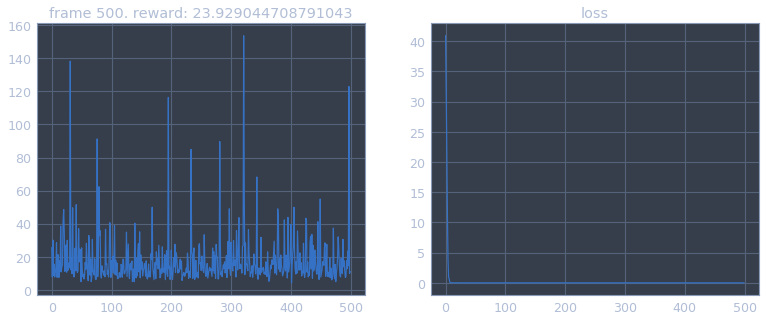

In [ ]:
state = env.reset()
#nn.clear_parameters()
for frame in range(1, max_frames):
    states    = []
    actions   = []
    episode_reward = 0
    
    for i in range (1, num_steps):
        #TODO 方策から行動決定
        action = env.action_space.sample() #test
        next_state, reward, done, _ = env.step(action)
        state = next_state
        
        states.append(state)
        actions.append(action)
        episode_reward += reward   
        
        if done or i == 100: #デバッグ用に100ステップで終了
            state = env.reset()
            overall_rewards.append(episode_reward)  
            break
            
    loss = compute_gradient(states, actions)
    losses.append(np.average(loss.d[0]))
    
    if frame % plot_interval == 0:
        plot(frame, overall_rewards, losses)

In [ ]:
#test
state = env.reset()
batch_size = 1
State = nn.Variable([batch_size, state_num]) 
Action = nn.Variable([batch_size, action_num])


In [ ]:
#test
Policy = Actor(State)
Value = Critic(State)

tP_ = np.array([[5.0,5.0,5.0]])
tV_ = np.array([[-10.0]])
tP = nn.Variable.from_numpy_array(tP_)
tV = nn.Variable.from_numpy_array(tV_)
print("tP : ",tP.d)
print("tV : ",tV.d)

loss_actor = F.squared_error(Policy,tP)
loss_critic = F.squared_error(Value,tV)
loss = loss_actor + loss_critic
print("loss",loss)
#Q_value = F.sum(F.one_hot(Action, (2,)) * Q, axis=1, keepdims=True)
#next_Q_value = F.max(Q, axis=1, keepdims=True)
#expected_Q_value = nn.Variable([batch_size, 1])

#損失関数定義
#loss = F.squared_error(Q_value, expected_Q_value)

In [ ]:
#test
State.d =state
Policy.forward()
Value.forward()

print("Policy : ",Policy.d)
print("Value : ",Value.d)
print("tP : ",tP.d)
print("tV : ",tV.d)

loss.forward()
solver_actor.zero_grad()
solver_critic.zero_grad()
loss.backward()
solver_actor.update()
solver_critic.update()

Policy.forward()
Value.forward()
print("Policy : ",Policy.d)
print("Value : ",Value.d)